## ステップ0) 準備


`database_name`にユニークな文字列(名前など)を入力してください。(ハンズオン参加者同士で名前・テーブル名の衝突を回避するため)

このノートブックの目的は、Databricksの分散計算能力を活用し、効率的にストアアイテムレベルで多数のきめ細かい予測を生成する方法を説明することです。 このノートブックは、以前Spark 2.x用に開発されたノートブックをSpark 3.x用に更新したものです。 このノートブックの **UPDATE** マークは、Spark 3.x または Databricks プラットフォームの新機能を反映するためのコードの変更を示しています。

In [0]:
dbutils.widgets.text('database_name', 'dorj')

In [0]:
database_name = dbutils.widgets.get('database_name')
print(database_name)

dorj_handson_database

In [0]:
%sh
curl -O 'https://sajpstorage.blob.core.windows.net/demo-asset-workshop2021/example/train.csv.zip'
unzip train.csv.zip

% Total % Received % Xferd Average Speed Time Time Time Current
 Dload Upload Total Spent Left Speed

 0 0 0 0 0 0 0 0 --:--:-- --:--:-- --:--:-- 0
 0 3133k 0 15971 0 0 15010 0 0:03:33 0:00:01 0:03:32 15010
 22 3133k 22 719k 0 0 357k 0 0:00:08 0:00:02 0:00:06 357k
100 3133k 100 3133k 0 0 1258k 0 0:00:02 0:00:02 --:--:-- 1258k
Archive: train.csv.zip
 inflating: train.csv

In [0]:
import shutil, os
train_dir = f'/dbfs/FileStore/{database_name}'
os.makedirs(train_dir, exist_ok=True)
train_path = os.path.join(train_dir, 'train.csv')
shutil.copy('train.csv', train_path)

print(train_path)

train_path_spark = train_path.replace('/dbfs', '')
print(train_path_spark)

/dbfs/FileStore/dorj_handson_database/train.csv
/FileStore/dorj_handson_database/train.csv

## ステップ1：データを調べる

学習用データセットとして、10店舗50アイテムの5年間の店舗・アイテム単位販売データを利用する。 このデータセットは過去のKaggleコンペティションの一部として公開されており、[こちら](https://www.kaggle.com/c/demand-forecasting-kernels-only/data)からダウンロードすることが可能です。

ダウンロード後、*train.csv.zip*ファイルを解凍し、解凍したCSVを*/FileStore/demand_forecast/train/*　にアップロードすることが可能です( [ドキュメント](https://docs.databricks.com/data/databricks-file-system.html#!#user-interface))。Databricksでデータセットにアクセスできるようになったので、モデリング準備のためにデータセットを探索することができます。

In [0]:
from pyspark.sql.types import *

# structure of the training data set
train_schema = StructType([
  StructField('date', DateType()),
  StructField('store', IntegerType()),
  StructField('item', IntegerType()),
  StructField('sales', IntegerType())
  ])

# read the training file into a dataframe
train = spark.read.csv(
  train_path_spark, # like 'dbfs:/FileStore/dorj_handson_database/train.csv'
  header=True, 
  schema=train_schema
  )

# make the dataframe queriable as a temporary view
train.createOrReplaceTempView('train')

# show data
display(train)

date,store,item,sales
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10
2013-01-06,1,1,12
2013-01-07,1,1,10
2013-01-08,1,1,9
2013-01-09,1,1,12
2013-01-10,1,1,9


需要予測を行う際、一般的な傾向や季節性に関心を持つことがよくあります。 まず、販売台数の年次推移を調べてみましょう。

In [0]:
%sql

SELECT
  year(date) as year, 
  sum(sales) as sales
FROM train
GROUP BY year(date)
ORDER BY year;

year,sales
2013,7941243
2014,9135482
2015,9536887
2016,10357160
2017,10733740


このデータから、各店舗の総販売台数が概して増加傾向にあることは明らかです。もし、これらの店舗が展開する市場についてもっと詳しい知識があれば、予測期間中に近づくと思われる最大の成長力があるかどうかを見極めたいと思うかもしれません。 しかし、そのような知識がなく、このデータセットをざっと見ただけでは、数日後、数ヶ月後、あるいは1年後の予測をするのが目的であれば、その期間中、直線的な成長が続くと想定してもよさそうです。

次に、季節性について見てみましょう。 各年の各月のデータを集計すると、1年ごとに明確な季節パターンが観察され、売上高の全体的な伸びとともに規模が拡大しているように見えます。

In [0]:
%sql

SELECT 
  TRUNC(date, 'MM') as month,
  SUM(sales) as sales
FROM train
GROUP BY TRUNC(date, 'MM')
ORDER BY month;

month,sales
2013-01-01,454904
2013-02-01,459417
2013-03-01,617382
2013-04-01,682274
2013-05-01,763242
2013-06-01,795597
2013-07-01,855922
2013-08-01,766761
2013-09-01,689907
2013-10-01,656587


週次で集計すると、日曜日（平日0日）をピークに、月曜日（平日1日）に大きく落ち込み、その後、1週間かけて着実に上昇し、日曜日の高値に戻るという季節パターンが顕著に観察される。 このパターンは、5年間の観測でかなり安定しているようです。

**UPDATE** Spark 3 の [Proleptic Gregorian calendar](https://databricks.com/blog/2020/07/22/a-comprehensive-look-at-dates-and-timestamps-in-apache-spark-3-0.html) への移行に伴い、CAST(DATE_FORMAT(date, 'u')) の 'u' オプションが削除されました。現在では、'E'を使用して同様の出力を提供しています。

In [0]:
%sql

SELECT
  YEAR(date) as year,
  (
    CASE
      WHEN DATE_FORMAT(date, 'E') = 'Sun' THEN 0
      WHEN DATE_FORMAT(date, 'E') = 'Mon' THEN 1
      WHEN DATE_FORMAT(date, 'E') = 'Tue' THEN 2
      WHEN DATE_FORMAT(date, 'E') = 'Wed' THEN 3
      WHEN DATE_FORMAT(date, 'E') = 'Thu' THEN 4
      WHEN DATE_FORMAT(date, 'E') = 'Fri' THEN 5
      WHEN DATE_FORMAT(date, 'E') = 'Sat' THEN 6
    END
  ) % 7 as weekday,
  AVG(sales) as sales
FROM (
  SELECT 
    date,
    SUM(sales) as sales
  FROM train
  GROUP BY date
 ) x
GROUP BY year, weekday
ORDER BY year, weekday;

year,weekday,sales
2013,0,25788.44230769231
2013,1,17269.69230769231
2013,2,20015.811320754718
2013,3,20150.153846153848
2013,4,21503.19230769231
2013,5,23071.096153846152
2013,6,24532.903846153848
2014,0,29901.0
2014,1,19791.98076923077
2014,2,23179.346153846152


さて、データ内の基本的なパターンを把握したところで、予測をどのように構築するか探ってみましょう。

## ステップ2：1つの予測を立てる

店舗と商品の個々の組み合わせについて予測を作成する前に、FBProphetの使い方を理解するために、1つの予測を作成することが役に立つかもしれません。

最初のステップは、モデルを訓練するための過去のデータセットを組み立てることです。

In [0]:
# query to aggregate data to date (ds) level
sql_statement = '''
  SELECT
    CAST(date as date) as ds,
    sales as y
  FROM train
  WHERE store=1 AND item=1
  ORDER BY ds
  '''

# assemble dataset in Pandas dataframe
history_pd = spark.sql(sql_statement).toPandas()

# drop any missing records
history_pd = history_pd.dropna()

さて、fbprophet ライブラリをインポートしますが、使用時に少し冗長になることがあるので、環境のロギング設定を微調整する必要があります。

In [0]:
from prophet import Prophet
import logging

# disable informational messages from fbprophet
logging.getLogger('py4j').setLevel(logging.ERROR)

データのレビューによると、全体的な成長パターンを線形に設定し、週単位と年単位の季節性パターンを評価できるようにする必要があるようです。また、季節パターンは売上高の全体的な成長とともに増加するようなので、季節性モードを乗算に設定するのもよいでしょう。

In [0]:
# set model parameters
model = Prophet(
  interval_width=0.95,
  growth='linear',
  daily_seasonality=False,
  weekly_seasonality=True,
  yearly_seasonality=True,
  seasonality_mode='multiplicative'
  )

# fit the model to historical data
model.fit(history_pd)

Out[9]: <prophet.forecaster.Prophet at 0x7fe5981fd400>

さて、学習済みモデルができたので、それを使って90日予報を作成してみましょう。

In [0]:
# define a dataset including both historical dates & 90-days beyond the last available date
future_pd = model.make_future_dataframe(
  periods=90, 
  freq='d', 
  include_history=True
  )

# predict over the dataset
forecast_pd = model.predict(future_pd)

display(forecast_pd)

ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
2013-01-01T00:00:00.000+0000,15.603425152213632,1.0547708230445494,18.18090618887492,15.603425152213632,15.603425152213632,-0.35587465674151963,-0.35587465674151963,-0.35587465674151963,-0.08871978715198106,-0.08871978715198106,-0.08871978715198106,-0.2671548695895386,-0.2671548695895386,-0.2671548695895386,0.0,0.0,0.0,10.050561582177611
2013-01-02T00:00:00.000+0000,15.609122142738732,1.7067989483773895,18.63813159653016,15.609122142738732,15.609122142738732,-0.3256291853559665,-0.3256291853559665,-0.3256291853559665,-0.05894952696059454,-0.05894952696059454,-0.05894952696059454,-0.266679658395372,-0.266679658395372,-0.266679658395372,0.0,0.0,0.0,10.52633641527694
2013-01-03T00:00:00.000+0000,15.614819133263833,2.3411502217998197,19.50128595541996,15.614819133263833,15.614819133263833,-0.29238815814235464,-0.29238815814235464,-0.29238815814235464,-0.025370114923134804,-0.025370114923134804,-0.025370114923134804,-0.26701804321921985,-0.26701804321921985,-0.26701804321921985,0.0,0.0,0.0,11.049230927162823
2013-01-04T00:00:00.000+0000,15.620516123788933,3.3141797750622586,21.168286312952894,15.620516123788933,15.620516123788933,-0.21651382052017404,-0.21651382052017404,-0.21651382052017404,0.051615968838058655,0.051615968838058655,0.051615968838058655,-0.2681297893582327,-0.2681297893582327,-0.2681297893582327,0.0,0.0,0.0,12.238458499330413
2013-01-05T00:00:00.000+0000,15.626213114314034,5.393432498528969,22.655891505636486,15.626213114314034,15.626213114314034,-0.11871449307863874,-0.11871449307863874,-0.11871449307863874,0.15123628647016457,0.15123628647016457,0.15123628647016457,-0.2699507795488033,-0.2699507795488033,-0.2699507795488033,0.0,0.0,0.0,13.771155145709466
2013-01-06T00:00:00.000+0000,15.631910104839134,6.320040895449159,22.847338142030697,15.631910104839134,15.631910104839134,-0.08082579386051095,-0.08082579386051095,-0.08082579386051095,0.1915699006353478,0.1915699006353478,0.1915699006353478,-0.27239569449585876,-0.27239569449585876,-0.27239569449585876,0.0,0.0,0.0,14.368448561059369
2013-01-07T00:00:00.000+0000,15.637607095364231,-0.8833707126277477,16.60380565653398,15.637607095364231,15.637607095364231,-0.49674392787380955,-0.49674392787380955,-0.49674392787380955,-0.22138272690742022,-0.22138272690742022,-0.22138272690742022,-0.27536120096638933,-0.27536120096638933,-0.27536120096638933,0.0,0.0,0.0,7.86972072426565
2013-01-08T00:00:00.000+0000,15.643304085889332,1.2063102655514981,18.163435027611058,15.643304085889332,15.643304085889332,-0.36744933787574324,-0.36744933787574324,-0.36744933787574324,-0.0887197871519481,-0.0887197871519481,-0.0887197871519481,-0.2787295507237952,-0.2787295507237952,-0.2787295507237952,0.0,0.0,0.0,9.895182357340387
2013-01-09T00:00:00.000+0000,15.649001076414432,2.1873464479882054,19.021212544399283,15.649001076414432,15.649001076414432,-0.34132201092984726,-0.34132201092984726,-0.34132201092984726,-0.05894952696090946,-0.05894952696090946,-0.05894952696090946,-0.2823724839689378,-0.2823724839689378,-0.2823724839689378,0.0,0.0,0.0,10.307652559969315
2013-01-10T00:00:00.000+0000,15.654698066939531,2.000109331253274,18.84553852219895,15.654698066939531,15.654698066939531,-0.31152543928574117,-0.31152543928574117,-0.31152543928574117,-0.025370114923832114,-0.025370114923832114,-0.025370114923832114,-0.28615532436190905,-0.28615532436190905,-0.28615532436190905,0.0,0.0,0.0,10.77786137475055


私たちのモデルの性能はどうだったでしょうか？ここでは、私たちのモデルの一般的な傾向と季節的な傾向をグラフで見ることができます。

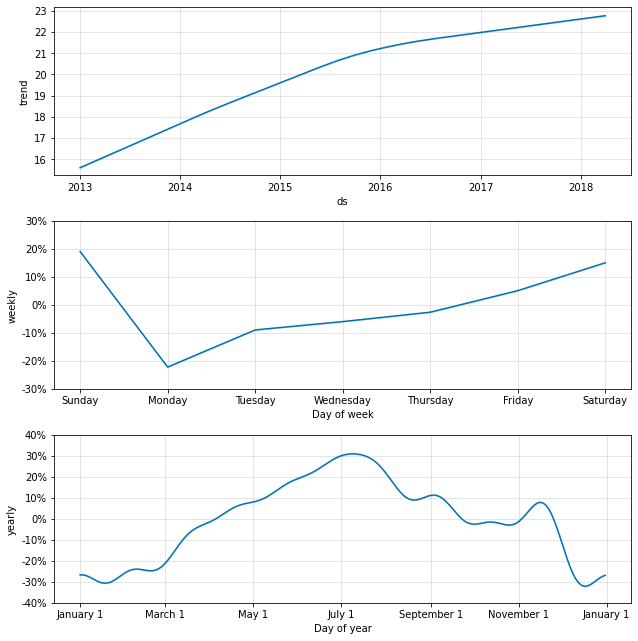

In [0]:
trends_fig = model.plot_components(forecast_pd)
display(trends_fig)

ここでは、グラフを見やすくするために、過去1年分のデータに限定していますが、実際のデータと予測データがどのように一致しているか、また、将来の予測も見ることができます。
ここでは、グラフを見やすくするために、過去1年分のデータに限定していますが、実際のデータと予測データがどのように一致しているか、また、将来の予測も見ることができます。

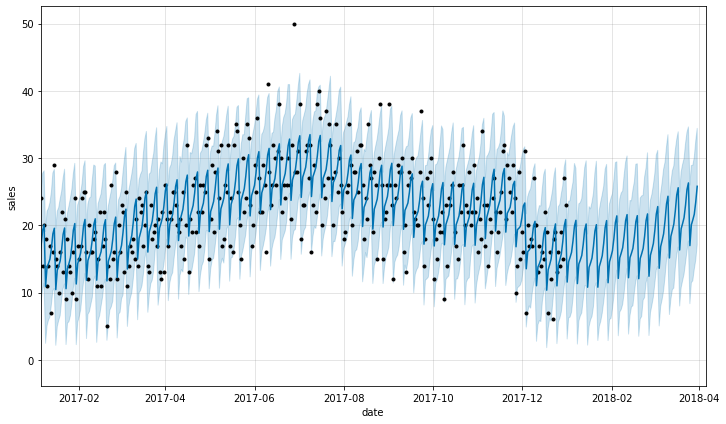

In [0]:
predict_fig = model.plot( forecast_pd, xlabel='date', ylabel='sales')

# adjust figure to display dates from last year + the 90 day forecast
xlim = predict_fig.axes[0].get_xlim()
new_xlim = ( xlim[1]-(180.0+365.0), xlim[1]-90.0)
predict_fig.axes[0].set_xlim(new_xlim)

display(predict_fig)

**注** この可視化は色々含まれていて一見複雑に見えます。Bartosz Mikulskiが[優れた内訳](https://www.mikulskibartosz.name/prophet-plot-explained/)を提供しており、それをチェックする価値は十分にあります。 簡単に言うと、黒い点は我々の実績を、濃い青色の線は我々の予測を、薄い青色の帯は我々の（95％）不確実性区間を表しています。

目視検査は有用ですが、予測を評価するより良い方法は、セット内の実際の値に対する予測値の平均絶対誤差、平均二乗誤差、ルート平均二乗誤差の値を計算することです。

**UPDATE** pandasの機能の変更により、日付文字列を正しいデータ型に変換するために*pd.to_datetime*を使用する必要があります。

In [0]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from datetime import date

# get historical actuals & predictions for comparison
actuals_pd = history_pd[ history_pd['ds'] < date(2018, 1, 1) ]['y']
predicted_pd = forecast_pd[ forecast_pd['ds'] < pd.to_datetime('2018-01-01') ]['yhat']

# calculate evaluation metrics
mae = mean_absolute_error(actuals_pd, predicted_pd)
mse = mean_squared_error(actuals_pd, predicted_pd)
rmse = sqrt(mse)

# print metrics to the screen
print( '\n'.join(['MAE: {0}', 'MSE: {1}', 'RMSE: {2}']).format(mae, mse, rmse) )

MAE: 3.486448296532775
MSE: 19.38884076928159
RMSE: 4.403276140475588

FBProphetは、あなたの予測が時間とともにどのように持ちこたえるか評価するための[追加手段](https://facebook.github.io/prophet/docs/diagnostics.html)を提供します。予測モデルを構築するときに、これらや追加のテクニックを使うことを強くお勧めしますが、ここではスケーリングの課題に焦点を当てるため、これを省きます。

## ステップ3：需要予測の生成をスケールさせる

このような仕組みが出来上がったところで、当初の目標であった、個々の店舗と商品の組み合わせに対する多数の細かいモデルと予測を構築することに取り組みます。 まず、店舗・商品・日付の粒度の売上データを集めることから始めます。

**注**: このデータセットのデータは、すでにこの粒度で集約されているはずですが、期待通りのデータ構造を確保するために明示的に集約しています。

In [0]:
sql_statement = '''
  SELECT
    store,
    item,
    CAST(date as date) as ds,
    SUM(sales) as y
  FROM train
  GROUP BY store, item, ds
  ORDER BY store, item, ds
  '''

store_item_history = (
  spark
    .sql( sql_statement )
    .repartition(sc.defaultParallelism, ['store', 'item'])
  ).cache()

店舗・アイテム・日付のレベルで集約されたデータを、どのようにFBProphetに渡すかを検討する必要があります。もし我々のゴールが各店舗と商品の組み合わせのモデルを構築することであるなら、先ほど組み立てたデータセットから店舗商品のサブセットを渡して、そのサブセットでモデルをトレーニングし、店舗商品予測を受け取る必要があります。予測はこのような構造のデータセットとして返されることを期待します。ここでは、予測が組み立てられた店舗とアイテムの識別子を保持し、出力をProphetモデルによって生成されたフィールドの関連するサブセットだけに限定しています。

In [0]:
from pyspark.sql.types import *

result_schema =StructType([
  StructField('ds',DateType()),
  StructField('store',IntegerType()),
  StructField('item',IntegerType()),
  StructField('y',FloatType()),
  StructField('yhat',FloatType()),
  StructField('yhat_upper',FloatType()),
  StructField('yhat_lower',FloatType())
  ])

モデルをトレーニングして予測を生成するために、Pandasの関数を活用します。 この関数は店舗と商品の組み合わせで構成されるデータのサブセットを受け取るように定義します。 この関数は、前のセルで特定されたフォーマットで予測を返します。

**UPDATE** Spark 3.0では、pandas関数がpandas UDFにあった機能を置き換えます。 非推奨のpandas UDF構文はまだサポートされていますが、時間の経過とともに段階的に廃止される予定です。 新しい、合理化されたpandas functions APIの詳細については、[このドキュメント](https://databricks.com/blog/2020/05/20/new-pandas-udfs-and-python-type-hints-in-the-upcoming-release-of-apache-spark-3-0.html)を参照してください。

In [0]:
def forecast_store_item( history_pd: pd.DataFrame ) -> pd.DataFrame:
  
  # TRAIN MODEL AS BEFORE
  # --------------------------------------
  # remove missing values (more likely at day-store-item level)
  history_pd = history_pd.dropna()
  
  # configure the model
  model = Prophet(
    interval_width=0.95,
    growth='linear',
    daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=True,
    seasonality_mode='multiplicative'
    )
  
  # train the model
  model.fit( history_pd )
  # --------------------------------------
  
  # BUILD FORECAST AS BEFORE
  # --------------------------------------
  # make predictions
  future_pd = model.make_future_dataframe(
    periods=90, 
    freq='d', 
    include_history=True
    )
  forecast_pd = model.predict( future_pd )  
  # --------------------------------------
  
  # ASSEMBLE EXPECTED RESULT SET
  # --------------------------------------
  # get relevant fields from forecast
  f_pd = forecast_pd[ ['ds','yhat', 'yhat_upper', 'yhat_lower'] ].set_index('ds')
  
  # get relevant fields from history
  h_pd = history_pd[['ds','store','item','y']].set_index('ds')
  
  # join history and forecast
  results_pd = f_pd.join( h_pd, how='left' )
  results_pd.reset_index(level=0, inplace=True)
  
  # get store & item from incoming data set
  results_pd['store'] = history_pd['store'].iloc[0]
  results_pd['item'] = history_pd['item'].iloc[0]
  # --------------------------------------
  
  # return expected dataset
  return results_pd[ ['ds', 'store', 'item', 'y', 'yhat', 'yhat_upper', 'yhat_lower'] ]  

この関数の中では多くのことが行われていますが、モデルの学習と予測が行われる最初の2つのブロックのコードをこのノートブックの前の部分のセルと比較すると、コードは以前とほとんど同じであることがわかります。本当に新しいコードが導入されているのは、必要な結果セットの組み立てだけで、それはかなり標準的なPandasのデータフレーム操作で構成されています。

では、pandasの関数を呼び出して、予測を作ってみましょう。 これは、店舗とアイテムの履歴データセットをグループ化することによって行います。 そして、各グループに関数を適用し、データ管理のために今日の日付を *training_date* として追加します。

**UPDATE** 前回のアップデートで、pandas UDFの代わりにapplyInPandas()を使ってpandas関数を呼び出しています。

In [0]:
from pyspark.sql.functions import current_date

results = (
  store_item_history
    .groupBy('store', 'item')
      .applyInPandas(forecast_store_item, schema=result_schema)
    .withColumn('training_date', current_date() )
    ).cache()

results.createOrReplaceTempView('new_forecasts')

display(results)

ds,store,item,y,yhat,yhat_upper,yhat_lower,training_date
2013-01-01,1,5,11.0,8.076716,16.22036,0.9462326,2022-06-10
2013-01-02,1,5,6.0,8.363136,15.621341,0.27736396,2022-06-10
2013-01-03,1,5,8.0,9.526909,17.61104,1.888726,2022-06-10
2013-01-04,1,5,9.0,9.798821,17.437748,1.9300859,2022-06-10
2013-01-05,1,5,8.0,10.864719,18.687016,3.496173,2022-06-10
2013-01-06,1,5,13.0,11.67602,19.191854,3.8068635,2022-06-10
2013-01-07,1,5,11.0,6.606158,14.538913,-1.6661869,2022-06-10
2013-01-08,1,5,10.0,8.318136,15.759933,0.63331187,2022-06-10
2013-01-09,1,5,7.0,8.579538,16.554207,1.1577018,2022-06-10
2013-01-10,1,5,8.0,9.71757,17.313295,1.6264147,2022-06-10


予測結果を報告したいので、照会可能なテーブル構造で保存しておきましょう。

In [0]:
spark.sql(f'create database if not exists {database_name};')
spark.sql(f'use {database_name}')

Out[18]: DataFrame[]

In [0]:
%sql
-- create forecast table
create table if not exists forecasts (
  date date,
  store integer,
  item integer,
  sales float,
  sales_predicted float,
  sales_predicted_upper float,
  sales_predicted_lower float,
  training_date date
  )
using delta
partitioned by (training_date);

-- load data to it
insert into forecasts
select 
  ds as date,
  store,
  item,
  y as sales,
  yhat as sales_predicted,
  yhat_upper as sales_predicted_upper,
  yhat_lower as sales_predicted_lower,
  training_date
from new_forecasts;

num_affected_rows,num_inserted_rows
958000,958000


しかし、それぞれの予測はどの程度良い（あるいは悪い）のでしょうか？ pandasの関数テクニックを使って、以下のように各店舗商品の予測に対する評価指標を生成することができます。

In [0]:
# schema of expected result set
eval_schema =StructType([
  StructField('training_date', DateType()),
  StructField('store', IntegerType()),
  StructField('item', IntegerType()),
  StructField('mae', FloatType()),
  StructField('mse', FloatType()),
  StructField('rmse', FloatType())
  ])

# define function to calculate metrics
def evaluate_forecast( evaluation_pd: pd.DataFrame ) -> pd.DataFrame:
  
  # get store & item in incoming data set
  training_date = evaluation_pd['training_date'].iloc[0]
  store = evaluation_pd['store'].iloc[0]
  item = evaluation_pd['item'].iloc[0]
  
  # calulate evaluation metrics
  mae = mean_absolute_error( evaluation_pd['y'], evaluation_pd['yhat'] )
  mse = mean_squared_error( evaluation_pd['y'], evaluation_pd['yhat'] )
  rmse = sqrt( mse )
  
  # assemble result set
  results = {'training_date':[training_date], 'store':[store], 'item':[item], 'mae':[mae], 'mse':[mse], 'rmse':[rmse]}
  return pd.DataFrame.from_dict( results )

# calculate metrics
results = (
  spark
    .table('new_forecasts')
    .filter('ds < \'2018-01-01\'') # limit evaluation to periods where we have historical data
    .select('training_date', 'store', 'item', 'y', 'yhat')
    .groupBy('training_date', 'store', 'item')
    .applyInPandas(evaluate_forecast, schema=eval_schema)
    )

results.createOrReplaceTempView('new_forecast_evals')

もう一度言いますが、各予測のメトリクスを報告したいと思うでしょうから、これらを照会可能なテーブルに永続化します。

In [0]:
%sql

create table if not exists forecast_evals (
  store integer,
  item integer,
  mae float,
  mse float,
  rmse float,
  training_date date
  )
using delta
partitioned by (training_date);

insert into forecast_evals
select
  store,
  item,
  mae,
  mse,
  rmse,
  training_date
from new_forecast_evals;

num_affected_rows,num_inserted_rows
500,500


これで各店舗と商品の組み合わせの予測を作成し、それぞれについて基本的な評価指標を作成しました。 この予測データを見るために、簡単なクエリーを発行することができます（ここでは1～3店舗にわたる商品1に限定しています）。

In [0]:
%sql

SELECT
  store,
  date,
  sales_predicted,
  sales_predicted_upper,
  sales_predicted_lower
FROM forecasts a
WHERE item = 1 AND
      store IN (1, 2, 3) AND
      date >= '2018-01-01' AND
      training_date=current_date()
ORDER BY store

store,date,sales_predicted,sales_predicted_upper,sales_predicted_lower
1,2018-02-15,16.580868,24.963737,8.666228
1,2018-02-16,18.30237,27.391958,9.90741
1,2018-02-17,20.541977,28.596125,11.517166
1,2018-02-18,21.442623,30.213552,12.819362
1,2018-02-19,12.061211,20.116524,3.534065
1,2018-02-20,15.078218,23.832804,6.593976
1,2018-02-21,15.77273,24.32299,7.2350793
1,2018-02-22,16.56906,25.467869,7.973981
1,2018-02-23,18.367937,27.375628,9.879588
1,2018-02-24,20.698849,28.946047,12.126328


そして、これらのそれぞれについて、それぞれの予測の信頼性を評価するのに役立つ指標を取り出すことができます。

In [0]:
%sql

SELECT
  store,
  mae,
  mse,
  rmse
FROM forecast_evals a
WHERE item = 1 AND
      training_date=current_date()
ORDER BY store

store,mae,mse,rmse
1,3.4864485,19.388842,4.4032764
2,4.234534,27.934034,5.285266
3,3.9922068,25.207825,5.0207396
4,3.8169012,23.144577,4.810881
5,3.2822154,17.39446,4.1706667
6,3.2112038,16.17285,4.0215483
7,3.0864716,15.590087,3.9484284
8,4.307357,30.421188,5.5155406
9,3.8268247,23.397783,4.8371253
10,3.9558375,25.307636,5.0306697
